In [1]:
import sys
sys.path.append("..")
import functions
from functions import *
data = load_dataset()
!pip install optuna
import optuna

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###   CW2 Q2

The same dataset is again augmented with the engineered features of the last section following the One Hot Encoding pipeline. It will then be used to train the Neural Network (NN) later on until a predictive score of the NN is found. 

In [2]:
data.head()

,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),Crew Size,Mission Success (%),Fuel Consumption (tons),Payload Weight (tons),Launch Vehicle
0,MSN-0001,Mission-1,2025-01-01,Star,Titan,Colonization,7.05,5.2,526.68,64.3,21,100.0,731.88,99.78,SLS
1,MSN-0002,Mission-2,2025-01-08,Exoplanet,Betelgeuse,Colonization,41.76,23.0,234.08,84.4,72,89.6,4197.41,45.72,Starship
2,MSN-0003,Mission-3,2025-01-15,Asteroid,Mars,Exploration,49.22,28.8,218.68,98.6,16,98.6,4908.00,36.12,Starship
3,MSN-0004,Mission-4,2025-01-22,Exoplanet,Titan,Colonization,26.33,17.8,232.89,36.0,59,90.0,2569.05,40.67,Starship
4,MSN-0005,Mission-5,2025-01-29,Exoplanet,Proxima b,Mining,8.67,9.2,72.14,96.5,31,73.2,892.76,12.40,Starship


In [3]:
#one hot encoding my data. I am using the video One Hot Encoder with Python Machine Learning (Scikit-Learn) as reference https://www.youtube.com/watch?v=rsyrZnZ8J2o
data_2= data.copy()

#changing launch date to numerical value (number of days since 1st Jan 2000) https://www.geeksforgeeks.org/python/python-pandas-to_datetime/
data_2['Launch Date'] = pd.to_datetime(data_2['Launch Date'])#convert to datetime object
reference_date = pd.to_datetime('2000-01-01')#reference date
data_2['Launch Date'] = (data_2['Launch Date'] - reference_date).dt.days#convert to number of days since reference date

catagory_cols = ['Target Type', 'Target Name', 'Mission Type', 'Launch Vehicle']#listing the catagories for the one hot encoder
#number_cols = ['Launch Date','Distance from Earth (light-years)','Mission Duration (years)','Mission Cost (billion USD)','Scientific Yield (points)','Crew Size','Mission Success (%)','Fuel Consumption (tons)','Payload Weight (tons)']
X = data_2.drop(['Mission Success (%)', 'Mission ID', 'Mission Name'], axis=1)#splitting the data into useful features and target variable
y = data_2['Mission Success (%)']

catagory_cols = [c for c in catagory_cols if c in X.columns]#filtering the catagory columns 
number_cols = [c for c in X.columns if c not in catagory_cols]#filtering the numerical columns
print(catagory_cols)
print(number_cols)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), catagory_cols)
    ], remainder='passthrough'
)
gbr = GradientBoostingRegressor(loss='absolute_error',      # uses L1 loss instead of default squared error
    learning_rate=0.1,          # step size for each tree
    n_estimators=300,           # number of sequential trees
    max_depth=5,                # if 1, each tree is a "stump" (very shallow)
    random_state=42,            # for reproducibility
    max_features=5,              # max features considered per split
    min_samples_leaf=5,         # min samples per leaf node
    subsample=0.8               # fraction of samples used for fitting each tree
)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient boost regressor', gbr)])
model.fit(X_train, y_train)
pred_y = model.predict(X_test)



['Target Type', 'Target Name', 'Mission Type', 'Launch Vehicle']
['Launch Date', 'Distance from Earth (light-years)', 'Mission Duration (years)', 'Mission Cost (billion USD)', 'Scientific Yield (points)', 'Crew Size', 'Fuel Consumption (tons)', 'Payload Weight (tons)']


##  Feature Engineering and Model Improvements

### Initial Ideas
- Total person years = crew size *mission duration (gives the number of man hours required for longer or more harch missions like colonisation or mining)
- Cost per person year = mission cost/ total person years (the total payout the company will lose per year until the mission is successful and they turn a profit)
- Scientific efficiency = scientific yield/ cost
- Scientific yield per year = scientific yield / mission duration
- 'MpG' = payload weight / fuel consumption (miles per gallon equivalent) (how fuel efficient are the missions leading to some space bodies being more efficient to go to than others possibly due to gravity assists, varying trajectories like asteroids or many small trips like colonisation of a planet or moon)
- Human efficiency = scientific yield / crew size * mission duration (If the crew is working at a maximum human efficiency, it would make sense that the mission has a higher success rate)
- Cost per LY = mission cost / distance from earth (light-years)
- Energy efficiency = fuel consumption / payload weight *distance from earth
- Technology improvement = launch date (days since 1st Jan 2000) *scientific yield / mission success (%) (this would have to be logged as it gives a very large number even if scaled. Would make sense that an improvement in space travel leads to a higher chance of success on a space mission) 

### Non-linear Interactions 
- Top speeds of each type of rocket, scaled to be in 1000s of mph.
- Total mission duration there and back using distances in Ly and speeds in 1000mph.

### Model Improvements
Previously mentioned problems with scaling resolved changing features like cost and payload weight using standard scalar.

' https://www.geeksforgeeks.org/machine-learning/what-is-feature-engineering/'

In [4]:
data_2.columns 

Index(['Mission ID', 'Mission Name', 'Launch Date', 'Target Type',
       'Target Name', 'Mission Type', 'Distance from Earth (light-years)',
       'Mission Duration (years)', 'Mission Cost (billion USD)',
       'Scientific Yield (points)', 'Crew Size', 'Mission Success (%)',
       'Fuel Consumption (tons)', 'Payload Weight (tons)', 'Launch Vehicle'],
      dtype='object')

In [5]:
X_ohe = preprocessor.transform(data_2.drop(columns=["Mission ID", "Mission Name", "Mission Success (%)"]))
catagories = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(catagory_cols)
numericals = [c for c in data_2.drop(columns=["Mission ID", "Mission Name", "Mission Success (%)"]).columns if c not in catagory_cols]
all_cols = list(catagories)+numericals
New_df = pd.DataFrame(X_ohe, columns=all_cols)

In [6]:
#   creating new features listed above to give the model new channels to learn from, highlighting non linear relationships in the data
#   https://www.geeksforgeeks.org/machine-learning/what-is-feature-engineering/

# interaction features
New_df['total person years'] = New_df['Crew Size'] * New_df['Mission Duration (years)']
New_df['cost per person year'] = New_df['Mission Cost (billion USD)'] / New_df['total person years']
New_df['scientific efficiency'] = New_df['Scientific Yield (points)'] / New_df['Mission Cost (billion USD)']
New_df['scientific yield per year'] = New_df['Scientific Yield (points)'] / New_df['Mission Duration (years)']
New_df['MpG'] = New_df['Payload Weight (tons)'] / New_df['Fuel Consumption (tons)']
New_df['human efficiency'] = New_df['Scientific Yield (points)'] / (New_df['Crew Size'] * New_df['Mission Duration (years)'])
New_df['cost per LY'] = New_df['Mission Cost (billion USD)'] / New_df['Distance from Earth (light-years)']
New_df['energy efficiency'] = New_df['Fuel Consumption (tons)'] / (New_df['Payload Weight (tons)'] * New_df['Distance from Earth (light-years)'])
New_df['technology improvement'] = New_df['Launch Date'] * New_df['Scientific Yield (points)'] / data_2['Mission Success (%)']
New_df['technology improvement Log'] = np.log1p(New_df['technology improvement'])
New_df=New_df.drop(columns = ['technology improvement'])

# geographical features
top_speeds = {
    'Launch Vehicle_SLS': 24500,    #mph need to be scaled to 1000 mph
    'Launch Vehicle_Starship': 25031,
    'Launch Vehicle_Ariane 6': 24372,
    'Launch Vehicle_Falcon Heavy': 24600
}
New_df['Top Speed 1000mph'] = sum(New_df[col] * speed for col, speed in top_speeds.items()) / 1000

LY_miles = 5.879e+12 
target_list = target_columns = ['Target Type_Exoplanet', 'Target Type_Moon', 'Target Type_Planet']

def total_time(row):
    if any(row[col] >= 1 for col in target_list):#  I had to ask chatgpt for help wih this if statement line as i was having trouble getting it to work. I have left my original line commented so you can see where I got too
    #if New_df[target] for target,speed in target_list:  # target types for planets, exoplanets and moons
        round_trip_miles = row['Distance from Earth (light-years)'] * LY_miles*2
        speed_mph = row['Top Speed 1000mph']*1000  # converting back to mph
        time_hours = round_trip_miles / speed_mph
        time_years = time_hours / (24*365.25)
        #scaling as to not skew the data too much
        time_years_scaled = time_years / 1e6

        return row['Mission Duration (years)']+ time_years_scaled #this gives time in years that number in the millions, skewing my data so I will need to normalise each result as not to affect the gradient boost as it is scale sensative
    else:
        return row['Mission Duration (years)']
New_df['Total Mission Time ( Mega years, (1,000,000))'] = New_df.apply(total_time, axis=1)

#mean cost per target type post one hot encoding
New_df["Target Type"] = New_df[[
    "Target Type_Exoplanet",
    "Target Type_Moon",
    "Target Type_Planet",
    "Target Type_Star",
    "Target Type_Asteroid"
]].idxmax(axis=1)
New_df["Target Type"] = New_df["Target Type"].str.replace("Target Type_", "")
mean_cost_map = New_df.groupby("Target Type")["Mission Cost (billion USD)"].mean()
New_df["Mean Cost per Target Type"] = New_df["Target Type"].map(mean_cost_map)

#scaling the larger columns like Mission cost and Fuel consumption and mean cost
scalar = StandardScaler()
New_df['Mission Cost Log'] = np.log1p(New_df['Mission Cost (billion USD)'])
New_df['Mission Cost Scaled'] = scalar.fit_transform(New_df[['Mission Cost Log']])
New_df=New_df.drop(columns = ['Mission Cost (billion USD)'])
New_df['Fuel Consumption (tons) Scaled']=scalar.fit_transform(New_df[['Fuel Consumption (tons)']])
New_df=New_df.drop(columns = ['Fuel Consumption (tons)'])
New_df['mean Cost Log'] = np.log1p(New_df['Mean Cost per Target Type'])
New_df['Mean Cost per Target Type Scaled'] = scalar.fit_transform(New_df[['mean Cost Log']])
New_df=New_df.drop(columns = ['Mean Cost per Target Type','mean Cost Log','Mission Cost Log','Target Type'])

#bins for scientific yield
bins = [0,25,50,75,100]
labels = [0,1,2,3]
New_df['Scientific Yield Catagories']=pd.cut(New_df['Scientific Yield (points)'],bins=bins, labels=labels,include_lowest=True)
key = {0:'Fail 0-25',1:'minor success 26-50',2:'success 51-75',3:'major success 75+'}
print(key)


{0: 'Fail 0-25', 1: 'minor success 26-50', 2: 'success 51-75', 3: 'major success 75+'}


#   CW PART B- Nerual Network on **Space Mission Dataset**

For a tabular style dataset like this, the best type of neural network is a Multi Layer Perceptron Regressor. This is because it predicts continuous discrete data such as **Mission Success %** and also excels at capturing non-linear relationships in the data, unlike models such as linear regression. They can also handle complex patterns and work well when there’s a lot of data with intricate features, such as a post feature engineering dataset with lots of added columns and cross correlation. 

In order to build it myself I followed the references and examples from these links:
   https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
   https://www.youtube.com/watch?v=NpcdJyxv_3w
   https://www.youtube.com/watch?v=LqQsjQpX4xk

In [7]:
X = New_df.values.astype(np.float32)#   converting to a long type float from integers
y = data['Mission Success (%)'].values.astype(np.float32)
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)
print(X_tensor.shape)
print(y_tensor.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.1, random_state=42)#    90% split after train and validation split 
train_dataset = TensorDataset(X_train,y_train)
validation_dataset = TensorDataset(X_val,y_val)

train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True )
validation_loader = DataLoader(validation_dataset,batch_size=64,shuffle=False )

torch.Size([500, 41])
torch.Size([500, 1])


In [8]:
#   making the Multi Layer Perceptron regression neural network model

class myNN(nn.Module):
    def __init__(self,dims):#dims here is dimensions of input as a dataset cant be flattened (Asked chatgpt for help converting from a picture based model to a dimsneional array type model as originally self.flatten = nn.Flatten() was not working properly) 
        super().__init__()
        # 5 hidden layers of 16 neurons each
        self.hidden = nn.Sequential(
            nn.Linear(dims, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        # Output layer 
        self.output = nn.Linear(16, 1)# output layer must have 1 neuron as for my regression model, the output is a discrete variable (1 number)
    def forward(self,x):
        x=self.hidden(x)
        return self.output(x)
    
net = myNN(dims=X.shape[1])
print(net)

#   training and regression loss
criterion = nn.MSELoss()
optimiser=optim.Adam(net.parameters(),lr=0.001)


myNN(
  (hidden): Sequential(
    (0): Linear(in_features=41, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
  )
  (output): Linear(in_features=16, out_features=1, bias=True)
)


##  Training the Model

Before the model can predict values, it must be fed the training dataset from above.   
- Firstly, number of epochs/ the number of run times over the data is decided upon. (The higher the epoch count the better the model will predict but is at risk of learning the data and not predicting, called overfitting). Too few and the outcome will be random, too many and the model just learns what comes next in the sequence of data and doesn't predict anything.
- The model net is set to training mode and put through the for loop for searching for x and y batch values from the loader definined above. Then, epoch loss is defined for each iteration giving us how poor the model did each iteration, this number shrinks every iteration signifying our model is learning.
- Then the model net is set to validation mode, which is where it is tested on the other half of the test train split data that is has not seen before. The same paramaters are defined in the for loop and predictions are saved to later be used to define accuracy within a tolerance (5%). 
- Final test accuracy is printed at the bottom telling us how well our model did. 

In [9]:
epochs = 100 #  the number of epochs the model is trained with will determine how well it learns the data
for epoch in range(epochs):
    net.train()#    training mode
    running_loss = 0
    for X_batch,y_batch in train_loader:
        optimiser.zero_grad()       # zero the gradient buffers
        outputs = net(X_batch)       # forward pass
        loss = criterion(outputs, y_batch)  # compute loss
        loss.backward()             # backward pass
        optimiser.step()            # update weights
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss/len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

val_loss = 0
net.eval()# validation mode
all_preds =[]
all_trues =[]
with torch.no_grad():
    for X_batch, y_batch in validation_loader:
        preds = net(X_batch)
        loss = criterion(preds, y_batch)
        val_loss += loss.item() * X_batch.size(0)
        all_preds.append(preds)
        all_trues.append(y_batch)
all_preds = torch.cat(all_preds).flatten()
all_trues = torch.cat(all_trues).flatten()
rmse = torch.sqrt(torch.mean((all_preds-all_trues)**2))
tol = 5.0 #tolerance percentage +- 5%
in_tol = torch.abs(all_preds-all_trues)<=tol
accuracy = 100*torch.sum(in_tol)/len(all_trues)

val_loss /= len(validation_loader.dataset)
print(f"Epoch {epoch+1}/{epochs} | Val Loss: {val_loss:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test Accuracy (±{tol}%): {accuracy:.2f}%")




Epoch 1/100, Loss: 8703.4649
Epoch 2/100, Loss: 8697.0499
Epoch 3/100, Loss: 8691.7236
Epoch 4/100, Loss: 8680.1319
Epoch 5/100, Loss: 8640.5115
Epoch 6/100, Loss: 8530.5224
Epoch 7/100, Loss: 8224.2207
Epoch 8/100, Loss: 7449.2672
Epoch 9/100, Loss: 5756.5650
Epoch 10/100, Loss: 2913.3316
Epoch 11/100, Loss: 672.1692
Epoch 12/100, Loss: 662.3641
Epoch 13/100, Loss: 249.2449
Epoch 14/100, Loss: 236.2503
Epoch 15/100, Loss: 157.4647
Epoch 16/100, Loss: 130.9978
Epoch 17/100, Loss: 113.5611
Epoch 18/100, Loss: 96.5086
Epoch 19/100, Loss: 88.1537
Epoch 20/100, Loss: 86.1815
Epoch 21/100, Loss: 77.3784
Epoch 22/100, Loss: 71.2284
Epoch 23/100, Loss: 69.8403
Epoch 24/100, Loss: 66.4514
Epoch 25/100, Loss: 61.5999
Epoch 26/100, Loss: 61.7493
Epoch 27/100, Loss: 55.6332
Epoch 28/100, Loss: 55.0482
Epoch 29/100, Loss: 51.0801
Epoch 30/100, Loss: 49.2609
Epoch 31/100, Loss: 47.5660
Epoch 32/100, Loss: 46.6797
Epoch 33/100, Loss: 46.2428
Epoch 34/100, Loss: 46.4662
Epoch 35/100, Loss: 43.1833
Ep

## Outcome

The average outcome for 5 reruns of the code was 56%. This is suboptimal for a neural network, however with the limited data it was given (about 500 rows and 28 columns), it performed admirably.

In order for test accuracy to increase, optuna was imported which is a counterpart for NN to a gridsearch for traditional machine learning. It runs my training code a number of times with different parameters until it finds the most optimal hyperparamaters and calls them study.best_trial. Using an example from YouTube and limited use of ChatGPT for conversion from ML to NN, I implemented optuna into my multi-layer perceptron regression algorithm. 

Below, the neural network is redefined but with variable parameters that can be changed by updating a variable later on, as well as give an input trial suggestion of my previous hyperparameters that optuna can use as a baseline.

source: 'https://www.youtube.com/watch?v=t-INgABWULw', 'https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py' and 'https://optuna.org/#code_examples'

In [10]:


class myNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, hidden_units, dropout_rate):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(in_dim, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_units

        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers',2,7)
    hidden_units = trial.suggest_int('hidden_units',16,128)
    dropout_rate = trial.suggest_float('dropout_rate',0.1,0.5)
    learning_rate = trial.suggest_float('learning_rate',0.0001,0.01)
    batch_size = trial.suggest_categorical('batch_size',[32,64,128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    net = myNN(input_dim=X.shape[1], hidden_layers=hidden_layers, hidden_units=hidden_units, dropout_rate=dropout_rate)
    criterion = nn.MSELoss()
    optimiser = optim.Adam(net.parameters(),lr=learning_rate)

    epochs = 50
    for epoch in range(epochs):
        net.train()#    training mode
        running_loss = 0
        for X_batch,y_batch in train_loader:
            optimiser.zero_grad()       # zero the gradient buffers
            outputs = net(X_batch)       # forward pass
            loss = criterion(outputs, y_batch)  # compute loss
            loss.backward()             # backward pass
            optimiser.step()            # update weights
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss/len(train_loader.dataset)
        #print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


    val_loss = 0
    net.eval()# validation mode
    all_preds =[]
    all_trues =[]
    with torch.no_grad():
        for X_batch, y_batch in validation_loader:
            preds = net(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds)
            all_trues.append(y_batch)
    all_preds = torch.cat(all_preds).flatten()
    all_trues = torch.cat(all_trues).flatten()
    rmse = torch.sqrt(torch.mean((all_preds-all_trues)**2))
    tol = 5.0 #tolerance percentage +- 5%
    in_tol = torch.abs(all_preds-all_trues)<=tol
    accuracy = 100*torch.sum(in_tol)/len(all_trues)

    val_loss /= len(validation_loader.dataset)
    #print(f"Epoch {epoch+1}/{epochs} | Val Loss: {val_loss:.4f}")
    #print(f"Test RMSE: {rmse:.4f}")
    #print(f"Test Accuracy (±{tol}%): {accuracy:.2f}%")

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)#    to improve accuracy change n trials

print("Best trial:")
trial = study.best_trial
print(trial.params)


[I 2025-12-11 16:31:27,928] A new study created in memory with name: no-name-5c259971-fce3-43d7-b331-9c6aeb6bb17f
[I 2025-12-11 16:31:30,064] Trial 0 finished with value: 51.73547393798828 and parameters: {'hidden_layers': 6, 'hidden_units': 124, 'dropout_rate': 0.352694736866512, 'learning_rate': 0.006964995376066989, 'batch_size': 32}. Best is trial 0 with value: 51.73547393798828.
[I 2025-12-11 16:31:30,613] Trial 1 finished with value: 85.85272216796875 and parameters: {'hidden_layers': 4, 'hidden_units': 92, 'dropout_rate': 0.1273488923771865, 'learning_rate': 0.00509827313875054, 'batch_size': 128}. Best is trial 0 with value: 51.73547393798828.
[I 2025-12-11 16:31:31,535] Trial 2 finished with value: 194.39195251464844 and parameters: {'hidden_layers': 7, 'hidden_units': 107, 'dropout_rate': 0.30621336154930107, 'learning_rate': 0.002561716989348403, 'batch_size': 128}. Best is trial 0 with value: 51.73547393798828.
[I 2025-12-11 16:31:32,365] Trial 3 finished with value: 71.825

Best trial:
{'hidden_layers': 6, 'hidden_units': 51, 'dropout_rate': 0.24459547223839967, 'learning_rate': 0.005458708109037861, 'batch_size': 32}


##  Results

Optuna here redefined the NN with new parameters each iteration until it found a series of params that best fit the data. 

Increasing the iterations n trials would find the best paramaters but also take longer and longer so a good safe agreement is around 30-50 trials. Each trial aims to minimise the validation loss variable, meaning the predicted values are closest to the actual values in **Mission Success (%)** from data.

## Retraining

The Multi-layer perceptron model is retrained for the final time with the most optimum hyperparamters and RMSE re-evaluated as well as accuracy that is compared to the machine learning gradient decent from Q1.

To do this, a new train test split was created with first an 80-20 split for training and temporary than another from the temporary 50-50 for testing and validation. This results in just enough data to train a NN on and enough for hyperparameter optimisation, with data left to test the new model on.

In [11]:
# First split: training and temp (80-20)
X_train_nn, X_temp_nn, y_train_nn, y_temp_nn = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# Second split: validation vs test (50-50 from the 20%) for hyperparam training on val and final testing
X_val_nn, X_test_nn, y_val_nn, y_test_nn = train_test_split(
    X_temp_nn, y_temp_nn, test_size=0.5, random_state=42
)

train_dataset_nn = TensorDataset(X_train_nn, y_train_nn)#    the final split should be 80-10-10
validation_dataset_nn = TensorDataset(X_val_nn, y_val_nn)
test_dataset_nn = TensorDataset(X_test_nn, y_test_nn)

Test Accuracy (±5.0%): 12.00%
Test Accuracy (±5.0%): 8.00%
Test Accuracy (±5.0%): 8.00%
Test Accuracy (±5.0%): 24.00%
Test Accuracy (±5.0%): 30.00%
Test Accuracy (±5.0%): 18.00%
Test Accuracy (±5.0%): 38.00%
Test Accuracy (±5.0%): 26.00%
Test Accuracy (±5.0%): 12.00%
Test Accuracy (±5.0%): 42.00%
Test Accuracy (±5.0%): 30.00%
Test Accuracy (±5.0%): 14.00%
Test Accuracy (±5.0%): 22.00%
Test Accuracy (±5.0%): 30.00%
Test Accuracy (±5.0%): 42.00%
Test Accuracy (±5.0%): 6.00%
Test Accuracy (±5.0%): 48.00%
Test Accuracy (±5.0%): 48.00%
Test Accuracy (±5.0%): 58.00%
Test Accuracy (±5.0%): 18.00%
Test Accuracy (±5.0%): 46.00%
Test Accuracy (±5.0%): 58.00%
Test Accuracy (±5.0%): 60.00%
Test Accuracy (±5.0%): 60.00%
Test Accuracy (±5.0%): 56.00%
Test Accuracy (±5.0%): 38.00%
Test Accuracy (±5.0%): 50.00%
Test Accuracy (±5.0%): 62.00%
Test Accuracy (±5.0%): 54.00%
Test Accuracy (±5.0%): 42.00%
Test Accuracy (±5.0%): 50.00%
Test Accuracy (±5.0%): 54.00%
Test Accuracy (±5.0%): 40.00%
Test Accuracy

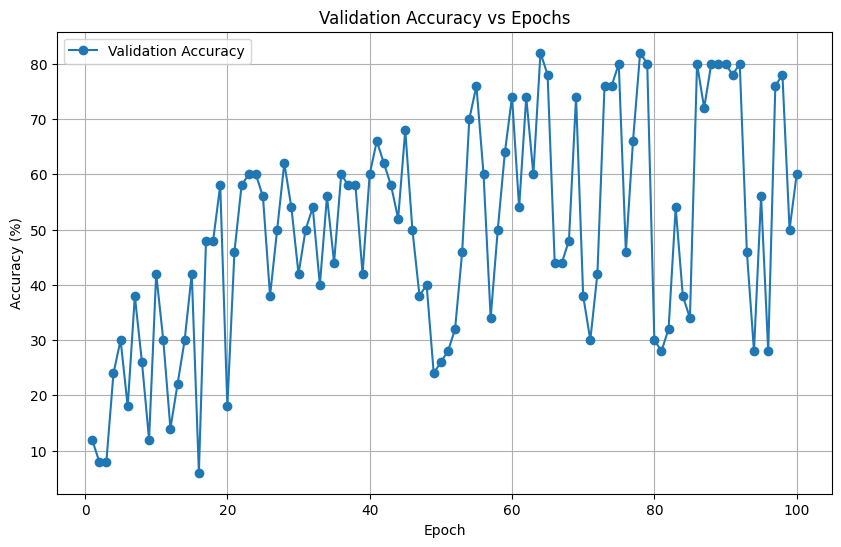

In [12]:
best = study.best_params
net = myNN(input_dim = X_train.shape[1],
            hidden_layers = best['hidden_layers'],
            hidden_units = best['hidden_units'],
            dropout_rate=best['dropout_rate']
)
optimiser = torch.optim.Adam(net.parameters(),lr=best['learning_rate'])
batch_size = best['batch_size']

train_loader_nn = DataLoader(train_dataset_nn, batch_size=batch_size, shuffle=True)
validation_loader_nn = DataLoader(validation_dataset_nn, batch_size=batch_size, shuffle=False)
test_loader_nn = DataLoader(test_dataset_nn, batch_size=batch_size)

val_accuracies=[]
epochs = 100
for epoch in range(epochs):
    net.train()#  
    running_loss = 0
    for X_batch,y_batch in train_loader_nn:
        optimiser.zero_grad()       
        outputs = net(X_batch)      
        loss = criterion(outputs, y_batch)  
        loss.backward()             
        optimiser.step()           
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss/len(train_loader_nn.dataset)

    net.eval()
    val_loss = 0
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for X_batch, y_batch in validation_loader_nn:
            preds = net(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds)
            all_trues.append(y_batch)
    all_preds = torch.cat(all_preds).flatten()
    all_trues = torch.cat(all_trues).flatten()
    rmse = torch.sqrt(torch.mean((all_preds-all_trues)**2))
    tol = 5.0 #tolerance percentage +- 5%
    in_tol = torch.abs(all_preds-all_trues)<=tol
    accuracy = 100*torch.sum(in_tol)/len(all_trues)
    val_accuracies.append(accuracy.item())
    val_loss /= len(validation_loader_nn.dataset)
    print(f"Test Accuracy (±{tol}%): {accuracy:.2f}%")

plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
net.eval()
with torch.no_grad():
    preds = net(X_test_nn)  
    preds = preds.flatten()
    true_vals = y_val_nn.flatten()  # or y_test



rmse_nn = torch.sqrt(torch.mean((preds - true_vals) ** 2))
r2_nn = r2_score(true_vals.numpy(), preds.numpy())

print(f"NN Test RMSE: {rmse_nn:.4f}")
print(f"NN Test R²: {r2_nn:.4f}")

NN Test RMSE: 11.9413
NN Test R²: -0.4373


## Evaluation

Finally, a graph is printed for each epoch's accuracy. Here you can see if the NN model is underfitting or overfitting the data as well as the randomness of the epoch to epoch accuracy/ how off the curve the line of best fit is. 

##  Epochs 0-80
As is clear to see, the multi-layer perceptron regressor from epochs 0-80 shows steady increase but with large randomness and RMSE. This is expected, however as the model is currently learning the new data it is being fed and with each guess is getting a higher and higher accuracy percentage. The randomness and large RMSE are due in part to my augmented data muddying the data correlations and relations somewhat. Some of my engineered features show relations between engineered features and other features, and not engineered features and the target data; resulting in overfitting in those feature environments. 

##  Epochs 80+
Increased epoch amount to 500 leads to higher accuracy in the data. This showed me that the model was done learning very early on and was plateauing which is not optimal. This plateau amplified the data perturbations and the error in accuracy jumped drastically epoch to epoch as the model was no longer learning and instead guessing at feature relations. 

##  RMSE and R^2
The RMSE and R^2 score signify how 'good' my neural network is at learning patterns and relations between features. Here the RMSE is approximately 11, meaning that each predicted value was around 11 off of the actual value of the **Mission Success**. This is to some degree larger than the RMSE I acquired from the Gradient Boost regressor (approximately 4) using the same data, partially due to the simple fact neural networks are designed to be using much larger data sets and aren't optimised to see complex realtions like a graident boost is. 
However, the R^2 score is a signifier of how accurate my model was of the data. A score of near 1 is perfect representation of the data, whilst 0 is no better than the mean. Here we find that my value of -0.3 (previously much higher approx -4.5) is a terrible result of overfitting and a clear indicator my NN is not learning enough of the relations to predict anything. Whereas my training and testing scores respectively for Machine Learning were 0.89 and 0.84, showing clear learning improvements from the graident boost regressor that the multi-layer perceptron regressor. 

##  Further Improvements
For future testing I would run my model net with the original data and then a select few feature engineered datasets to find what types of feature relations the model learns from most, as well as feed it some more non-linear relations such as features squared or the log of features. This would allow it to learn from a more diverse pool of feature engineering, or perhaps use a larger data pool to pull from, increasing the data points in the test train split.